# SMS

In this assignment, you will use the `SMS_train.csv` dataset to train a neural network that classifies SMS messages as spam or not spam, and then evaluate the trained model on the `SMS_test.csv` dataset.
    
***Notes:***

- Some parts of the code are already provided. **Do not modify the existing code.**
- Write your solution only in the sections marked with `### YOUR SOLUTION`.
- You can verify automatically graded tasks using the cell labeled `### TEST` after each function.

***IMPORTANT NOTE:***
- Name your Jupyter Notebook as `sms_{index}.ipynb`.
- For example, if your index is 123456, you should name your notebook as `sms_12346.ipynb`.

In [1]:
import hashlib
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def hash_data_frame(df):
    df_sorted = df.sort_index(axis=1).sort_values(by=list(df.columns))
    return hashlib.sha256(pd.util.hash_pandas_object(df_sorted, index=True).values).hexdigest()

In [3]:
def hash_series(series):
    series_str = ",".join(map(str, series.values))
    return hashlib.sha256(series_str.encode()).hexdigest()

In [4]:
def hash_vocab(vocab):
    items = sorted(vocab.items(), key=lambda x: x[1])  
    vocab_str = "\n".join(f"{k}:{v}" for k, v in items)
    return hashlib.sha256(vocab_str.encode("utf-8")).hexdigest()

In [5]:
def hash_sequences(sequences):
    flat = []
    for seq in sequences:
        flat.extend(seq)
        flat.append(-1)  # separator to preserve sequence boundaries
    return hashlib.sha256(str(flat).encode("utf-8")).hexdigest()

In [6]:
def hash_tensor(tensor):
    return hashlib.sha256(tensor.cpu().numpy().tobytes()).hexdigest()

In [7]:
def hash_number(x):
    return hashlib.sha256(str(x).encode("utf-8")).hexdigest()

In [8]:
def hash_loss_fn(x):
    return hashlib.sha256(type(x).__name__.encode()).hexdigest()

In [9]:
df_train = pd.read_csv("SMS_train.csv", encoding="latin-1")
df_test  = pd.read_csv("SMS_test.csv",  encoding="latin-1")

df_train.sample()

,S. No.,Message_body,Label
781,782,Urgent -call 09066649731from Landline. Your co...,Spam


In [28]:
### AUTOMATICALLY GRADED TASK
def preprocess_message_body(df):
    """
    Preprocesses the 'Message_body' column by converting all text to lowercase and removing the messages 
    containing more than 30 words and ensure that the resulting DataFrame has a sequential index. 

    Returns: 
        pandas DataFrame.
    """

    ### BEGIN SOLUTION
    df["Message_body"] = df["Message_body"].str.lower()
    df = df[df["Message_body"].str.split().apply(len) <= 30]
    df = df.reset_index(drop=True)

    return df
    ### END SOLUTION

In [29]:
df_train = preprocess_message_body(df_train)
df_test = preprocess_message_body(df_test)

In [30]:
### TEST
_df_train = pd.read_csv("SMS_train.csv", encoding="latin-1")
_df_test = pd.read_csv("SMS_test.csv", encoding="latin-1")
_df_train = preprocess_message_body(_df_train)
_df_test = preprocess_message_body(_df_test)
assert hash_data_frame(_df_train) == "a885cbf2337bfc9a0c224f8d231a9defa1b8096221df27baee847fcd4b66d727"
assert hash_data_frame(_df_test) == "862795718c7be040d8e929d7395b6e722605b31c0a8957b5cd6e932c146583a9"

In [46]:
### AUTOMATICALLY GRADED TASK
def partition_datasets(df_train, df_test):
    """
    Split the datasets into features (X) and target (y), where the feature used is `Message_body` and the target is `Label`.
    The validation dataset is obtaing from the training dataset using an 80:20 ratio.

    If you think encoding is necessary use df[column].astype("category").cat.codes

    Use `random_state=42` to ensure reproducibility.
    
    Return:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame] in the following order: 
        train_X, val_X, test_X, train_y, val_y, test_y
    """

    ### BEGIN SOLUTION

    train_X,test_X,train_y,test_y=df_train["Message_body"],df_test["Message_body"],df_train["Label"].astype("category").cat.codes,df_test["Label"].astype("category").cat.codes
    train_X,val_X,train_y,val_y=train_test_split(train_X,train_y,test_size=0.2,random_state=42)


    return train_X, val_X, test_X, train_y, val_y, test_y;
   
    ### END SOLUTION

In [47]:
train_X, val_X, test_X, train_y, val_y, test_y = partition_datasets(df_train, df_test)

In [48]:
## TEST
_df_train = pd.read_csv("SMS_train.csv", encoding="latin-1")
_df_test = pd.read_csv("SMS_train.csv", encoding="latin-1")
_train_X, _val_X, _test_X, _train_y, _val_y, _test_y = partition_datasets(_df_train, _df_test)
assert hash_series(_train_X) == "c481d42e0756a38566ddfdcc412d7b786cada2137b6333e1713b24ed0ece5b26"
assert hash_series(_val_X) == "83203ed4a564b98d81ed79147e72c01a03625498df544e3b59eebfecae6ffd71"
assert hash_series(_test_X) == "5d4840d43f05e88c52614a298d05e6cce8d050236f48ec7f51a63a0c52ca9ebb"
assert hash_series(_train_y) == "2fe06e2c319689dfbc64a9685fcc818e927c46c473db210892bd0bc6551b9aca"
assert hash_series(_val_y) == "dfe2ac8aed124b36059c1640c47d9beeeb677370cc8d3fe97e8002edf692e4d1"
assert hash_series(_test_y) == "b074c6cba93cbcca61a03cbf765771b14dc889a8afe548f8edc16872951cc8f0"

In [49]:
### AUTOMATICALLY GRADED TASK
def build_vocab(texts):
    """
    Builds a vocabulary dictionary from a list of text strings.

    The function should count word frequencies across all input texts and
    assign an integer index to each word. The vocabulary must include the
    special tokens "<PAD>" with index 0 and "<OOV>" with index 1. The remaining
    words should be added in descending order of frequency, such that all words
    from the texts are included.

    Parameters:
        texts (list of str): List of preprocessed text strings

    Returns:
        dict: A dictionary mapping words to integer indices
    """

    ### BEGIN SOLUTION

    counter = Counter()

    for sentence in texts:
        counter.update(sentence.split())

    # Special tokens
    vocab = {
        "<PAD>": 0,
        "<OOV>": 1
    }

    for idx, (word, _) in enumerate(
        counter.most_common(), start=2
    ):
        vocab[word] = idx

    return vocab

    ### END SOLUTION

In [50]:
vocab = build_vocab(train_X.values)

In [51]:
## TEST
assert hash_vocab(vocab) == "24e754192411a8025ea734f808d59e63119f1571f8d1f78f31c7543ccf64db42"

In [52]:
### AUTOMATICALLY GRADED TASK
def texts_to_sequences(texts, vocab):
    """
    Converts a list of text strings into sequences of integer indices using a
    given vocabulary.

    Each word in a text should be replaced by its corresponding index from the
    vocabulary. Words that are not present in the vocabulary must be mapped to
    the "<OOV>" token.

    Parameters:
    texts (List[str]): List of preprocessed text strings
    vocab (dict): Vocabulary mapping words to integer indices

    Returns:
        List[List[int]]: List of integer sequences corresponding to the input texts
    """  
    
    ### BEGIN SOLUTION

    sequences = []

    for sentence in texts:
        seq = [
            vocab.get(word, vocab["<OOV>"])
            for word in sentence.split()
        ]
        sequences.append(seq)

    return sequences
    
    ### END SOLUTION

In [53]:
train_X = texts_to_sequences(train_X.values, vocab)
val_X   = texts_to_sequences(val_X.values, vocab)
test_X  = texts_to_sequences(test_X.values, vocab)

In [54]:
##TEST
assert hash_sequences(train_X) == "ef7808b6a0a103dff51195be7106e88049b5ac088555e1c321eaa04a1d8a27dc"
assert hash_sequences(val_X) == "296741a8ec2fc52f965034fe5d8736a7fb85e6bab2ca3648360cbc4977fb451d"
assert hash_sequences(test_X) == "77257167e8a4a47f7101870edff64f23865f2658b1806435cec54fd7c60438fa"

In [56]:
### AUTOMATICALLY GRADED TASK
def pad(sequences, pad_value=0):
    """
    Pads a list of integer sequences so that all sequences have the same length.

    Shorter sequences should be padded with the specified padding value until
    they match the length of the longest sequence. The output should be a
    tensor suitable for batch processing in a neural network.

    Parameters:
        sequences (List[List[int]]): List of integer sequences
        pad_value (int): Value used for padding (default is 0)

    Returns:
        torch.Tensor: Padded tensor of shape (batch_size, max_sequence_length)
    """
    
    ### BEGIN SOLUTION

    return pad_sequence(
        [torch.tensor(seq, dtype=torch.long) for seq in sequences],
        batch_first=True,
        padding_value=pad_value
    )
   
    ### END SOLUTION

In [57]:
train_X = pad(train_X, pad_value=vocab["<PAD>"])
val_X   = pad(val_X,pad_value=vocab["<PAD>"])
test_X  = pad(test_X, pad_value=vocab["<PAD>"])

In [58]:
##TEST 
assert hash_tensor(train_X) == "27562520e0c10b077335722ac52b241f97a038edb7cbade08365972f3cbe8d43"
assert hash_tensor(val_X) == "5511dd5d71f44384098b4ae4bd47170369149794e51b3a209915310c2431964a"
assert hash_tensor(test_X) == "baf8d626727e02acd2e000f9a7945ed42122dcd44e519279f515de99e292bbe8"

In [59]:
train_y = torch.tensor(train_y.values, dtype=torch.float32)
val_y   = torch.tensor(val_y.values, dtype=torch.float32)
test_y  = torch.tensor(test_y.values, dtype=torch.float32)

In [60]:
def create_datasets(train_X, train_y, val_X, val_y, test_X, test_y):
    """
    Creates PyTorch TensorDataset objects for the training, validation,
    and test splits.

    Parameters:
        train_X (torch.Tensor): Training input features 
        train_y (torch.Tensor): Training target labels 
        val_X (torch.Tensor): Validation input features 
        val_y (torch.Tensor): Validation target labels 
        test_X (torch.Tensor): Test input features 
        test_y (torch.Tensor): Test target labels 
        
    Returns:
        train_dataset (TensorDataset): Dataset containing training inputs and targets.
        val_dataset (TensorDataset): Dataset containing validation inputs and targets.
        test_dataset (TensorDataset): Dataset containing test inputs and targets.
    """

    ### BEGIN SOLUTION

    train_dataset=TensorDataset(train_X,train_y)
    val_dataset=TensorDataset(val_X,val_y)
    test_dataset=TensorDataset(test_X,test_y)

    return train_dataset,val_dataset,test_dataset

    ### END SOLUTION

In [61]:
train_dataset, val_dataset, test_dataset = create_datasets(train_X, train_y, val_X, val_y, test_X, test_y)

In [62]:
##TEST
assert isinstance(train_dataset, TensorDataset)
assert isinstance(val_dataset, TensorDataset)
assert isinstance(test_dataset, TensorDataset)
assert len(train_dataset) == train_X.shape[0] == train_y.shape[0]
assert len(val_dataset) == val_X.shape[0] == val_y.shape[0]
assert len(test_dataset) == test_X.shape[0] == test_y.shape[0]

In [66]:
### AUTOMATICALLY GRADED TASK
def create_dataloaders(train_dataset, val_dataset, test_dataset):
    """
    Constructs PyTorch DataLoader objects for the training, validation,
    and test datasets with batch size 32.

    Parameters:
        train_dataset (TensorDataset): Dataset containing training samples.
        val_dataset (TensorDataset): Dataset containing validation samples.
        test_dataset (TensorDataset): Dataset containing test samples.

    Returns:
        train_loader (DataLoader): DataLoader that yields mini-batches from the training dataset.
        val_loader (DataLoader): DataLoader that yields mini-batches from the validation dataset.
        test_loader (DataLoader): DataLoader that yields mini-batches from the test dataset.
    """
    
    ### BEGIN SOLUTION

    train_loader=DataLoader(train_dataset,batch_size=32)
    val_loader=DataLoader(val_dataset,batch_size=32)
    test_loader=DataLoader(test_dataset,batch_size=32)

    return train_loader,val_loader,test_loader
   
    ### END SOLUTION

In [67]:
train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset)

In [68]:
##TEST
assert isinstance(train_loader, DataLoader)
assert isinstance(val_loader, DataLoader)
assert isinstance(test_loader, DataLoader)
xb, yb = next(iter(train_loader))
assert xb.shape[0] <= 32   
assert yb.shape[0] == xb.shape[0]

In [96]:
### AUTOGRADED TASK
class TextLSTM(nn.Module):
    """
    LSTM-based model for text classification.

    The architecture consists of the following components:
    1. embedding: An embedding layer that maps token indices to 128-dimensional vectors (use padding_idx=0).
    2. dropout1: A dropout layer with a rate of 20% for regularization.
    3. lstm: An LSTM layer with 256 hidden units to model sequential dependencies in the input text.
    4. dropout2: A dropout layer with a rate of 20% for regularization.
    5. fc: A final fully connected linear layer that produces the output logits.

    Note:
    No activation function is applied in the forward pass. The appropriate
    activation is applied implicitly by the loss function during training.
    """
    
    ### BEGIN SOLUTION

    def __init__(self, vocab_size: int):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, 128, padding_idx=0)
        self.dropout1 = nn.Dropout(0.20)
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.dropout2 = nn.Dropout(0.20)
        self.fc = nn.Linear(256, 1) 

    def forward(self, x):
        x = self.embedding(x)      
        x = self.dropout1(x)                
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout2(x)                
        return self.fc(x).squeeze(1)
               
    ### END SOLUTION

In [97]:
### AUTOGRADED TASK
def initialize_model():
    """
    Initializes and returns a TextLSTM model.

    Parameters:
        vocab_size (int): Size of the vocabulary

    Returns:
        torch.nn.Module
    """

    ### BEGIN SOLUTION

    return TextLSTM(len(vocab))
    ### END SOLUTION

In [98]:
model = initialize_model()

In [99]:
##TEST
assert hasattr(model, "embedding")
assert model.embedding.embedding_dim == 128
assert hash_number(model.embedding.num_embeddings) == "8d57a52196dfab7020a5cf06e22e81c32e263ca7797ffaf26fa5954d2a7943d6"

In [100]:
##TEST
assert hasattr(model, "dropout1") 
assert model.dropout1.p == 0.2

In [101]:
##TEST
assert hasattr(model, "lstm")
assert model.lstm.input_size == 128
assert model.lstm.hidden_size == 256

In [102]:
##TEST
assert hasattr(model, "dropout2") 
assert model.dropout2.p == 0.2

In [103]:
##TEST
assert hasattr(model, "fc") 
assert model.fc.in_features == 256
assert hash_number(model.fc.out_features) == "6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b"

In [110]:
### AUTOGRADED TASK
def get_loss_fn():
    """
    Define the loss function.

    Hint:
    Since no activation function is defined at the output layer, you should choose
    a loss function suitable for this task that internally applies the appropriate
    activation.

    Returns:
        loss_fn
    """
        
    ### BEGIN SOLUTION

    return nn.BCEWithLogitsLoss()
    
    ### END SOLUTION

In [111]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = get_loss_fn()

In [112]:
##TEST
assert hash_loss_fn(loss_fn) == "5d01f68444b94273dc184356c88edefa2a8f4088990a700401a0ccb9c01a712a"

In [113]:
def train(model, dataloader, loss_fn, optimizer):
    model.train()

    total_loss = 0
    for features, targets in dataloader:
        optimizer.zero_grad()

        outputs = model(features)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss

In [114]:
### AUTOGRADED TASK
def evaluate(model, dataloader, loss_fn):
    """
    Transform the logits using an activation function and apply a 0.5 threshold
    to produce binary (0 or 1) predictions.
    """
 
    model.eval()

    total_loss, correct, total = (0,)*3
    with torch.no_grad():
        for features, targets in dataloader:
            outputs = model(features)
            loss = loss_fn(outputs, targets)
            
            ### BEGIN SOLUTION1
            predictions = (torch.sigmoid(outputs) >= 0.5)            
            ### END SOLUTION

            correct += (predictions == targets).sum().item()
            total += targets.numel()

            total_loss += loss.item()

    accuracy = correct / total
    return total_loss, accuracy

In [115]:
def train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs):
    train_losses, val_losses = [], []
    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, loss_fn, optimizer)
        train_losses.append(train_loss)
        val_loss, _ = evaluate(model, val_loader, loss_fn)
        val_losses.append(val_loss)

        print(f"Epoch {epoch:3d}/{num_epochs} | train_loss={train_loss:.4f} val_loss={val_loss:.4f}")
                  
    return train_losses, val_losses

In [116]:
num_epochs = 5

In [117]:
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs)

Epoch   1/5 | train_loss=10.4700 val_loss=1.5335
Epoch   2/5 | train_loss=4.6040 val_loss=0.9380
Epoch   3/5 | train_loss=3.0735 val_loss=0.8833
Epoch   4/5 | train_loss=3.1796 val_loss=0.8486
Epoch   5/5 | train_loss=2.8693 val_loss=1.8909


<Axes: >

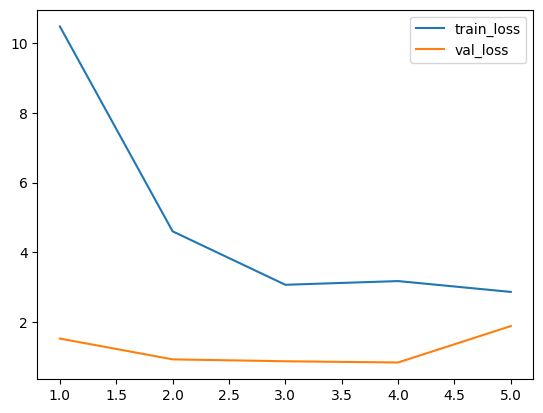

In [118]:
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label="train_loss")
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label="val_loss")

In [119]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn)

In [120]:
test_loss, test_acc

(5.892970972927287, 0.6)

In [121]:
##TEST
assert isinstance(test_acc, float)
assert 0.4 <= test_acc <= 1